In [13]:
# ================================================================
# CELDA 0 — Setup: constantes, configuración, utilidades, núcleo físico
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import json, os
from dataclasses import dataclass
from matplotlib import animation
from IPython.display import HTML

# Constantes SI
e   = 1.602176634e-19
m_e = 9.1093837015e-31
eps0= 8.8541878128e-12
c   = 299792458.0

@dataclass
class Config:
    B0: float = 200e-9      # [T]
    ne: float = 2.0e6       # [m^-3]
    omega_min: float = 2*np.pi*100.0
    omega_max: float = 2*np.pi*6000.0
    n_omega: int = 200
    E0: float = 0.05        # [V/m]
    phi0: float = 0.0       # [rad]
    T: float = 0.2          # [s]
    dt: float = 1e-5        # [s]
    x0: float = 0.0         # [m]
    y0: float = 0.0         # [m]
    vx0: float = 1e4        # [m/s]
    vy0: float = 0.0        # [m/s]
    seed: int = 42
    plot_semilog_k: bool = True
    save_csv: bool = False

CFG = Config()


if os.path.exists("config.json"):
    try:
        with open("config.json","r") as f:
            data=json.load(f)
        for k,v in data.items():
            if hasattr(CFG,k): setattr(CFG,k,v)
        print("config.json carregado.")
    except Exception as err:
        print("Aviso: não foi possível ler config.json:", err)

# Funciones físicas
def omega_pe(ne):  return np.sqrt(ne*e**2/(eps0*m_e))
def Omega_e(B0):  return e*B0/m_e

def n_cold_R(omega, wpe, Oe):
    n2 = 1.0 - (wpe**2)/(omega*(omega - Oe))
    n  = np.full_like(omega, np.nan, dtype=float)
    mask = n2 >= 0.0
    n[mask] = np.sqrt(n2[mask])
    return n

def k_from_n_omega(n, omega):
    k = np.full_like(omega, np.nan, dtype=float)
    mask = np.isfinite(n)
    k[mask] = n[mask]*omega[mask]/c
    return k

# RHS partícula: estado y=[x, y, vx, vy]
def rhs_particle(t, y, params):
    x, y_, vx, vy = y
    E0 = params["E0"]; k = params["k"]; omega = params["omega"]
    B0 = params["B0"]; phi0 = params["phi0"]
    Ex = E0*np.cos(k*x - omega*t + phi0)
    dvx = -(e/m_e)*(Ex + vy*B0)
    dvy =  (e/m_e)*(vx*B0)
    dx  = vx
    dy  = vy
    return np.array([dx, dy, dvx, dvy], float)

# Integrador RK4
def rk4(f, y0, t0, tf, dt, params):
    nsteps = int(np.ceil((tf - t0)/dt))
    T = np.empty(nsteps+1); Y = np.empty((nsteps+1, len(y0)))
    t = t0; y = np.array(y0, float)
    T[0]=t; Y[0]=y
    for i in range(1, nsteps+1):
        k1 = f(t, y, params)
        k2 = f(t+0.5*dt, y+0.5*dt*k1, params)
        k3 = f(t+0.5*dt, y+0.5*dt*k2, params)
        k4 = f(t+dt, y+dt*k3, params)
        y = y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
        T[i]=t; Y[i]=y
    return T, Y

# Dispersión k(ω)
def compute_dispersion(cfg: Config):
    wpe = omega_pe(cfg.ne)
    Oe  = Omega_e(cfg.B0)
    omegas = np.linspace(cfg.omega_min, cfg.omega_max, cfg.n_omega)
    n = n_cold_R(omegas, wpe, Oe)
    k = k_from_n_omega(n, omegas)
    return omegas, k, wpe, Oe

# Util: energía cinética
def kinetic_energy(vx, vy): return 0.5*m_e*(vx**2 + vy**2)

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Esta célula define constantes físicas (SI), parâmetros do experimento
# (CFG) e as rotinas centrais:
# - Dispersão fria do modo R (n_cold_R e k_from_n_omega)
# - Dinâmica de partícula-teste em B0 ẑ com onda elétrica Ex(x,t)
# - Integrador RK4 e utilitários (energia cinética)
# Fisicamente, isto fixa o cenário: plasma frio, B0 uniforme, onda 1D.



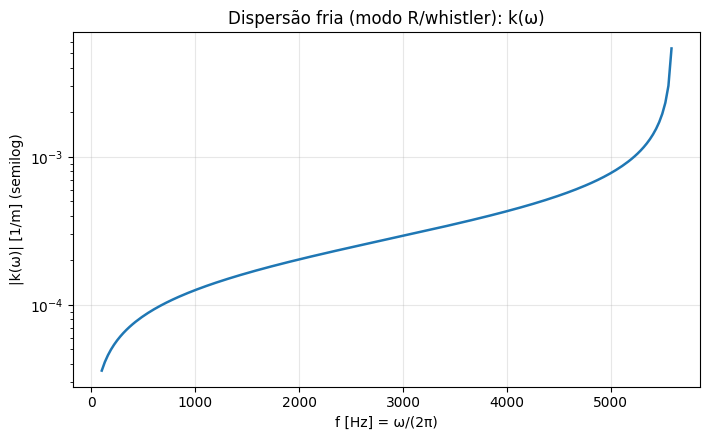

In [4]:
# ================================================================
# CELDA 1 — Figura: Dispersão fria (modo R/whistler) — k(ω)
# ================================================================
omegas, k_vals, wpe, Oe = compute_dispersion(CFG)
mask = np.isfinite(k_vals)

plt.figure(figsize=(7.2,4.5))
if CFG.plot_semilog_k:
    plt.semilogy(omegas[mask]/(2*np.pi), np.abs(k_vals[mask]), lw=1.8)
    plt.ylabel("|k(ω)| [1/m] (semilog)")
else:
    plt.plot(omegas[mask]/(2*np.pi), k_vals[mask], lw=1.8)
    plt.ylabel("k(ω) [1/m]")
plt.xlabel("f [Hz] = ω/(2π)")
plt.title("Dispersão fria (modo R/whistler): k(ω)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Calcula a relação de dispersão do modo whistler (frio) e plota k(ω).
# A expressão usada é n^2 = 1 - ω_pe^2 / [ω(ω - Ω_e)], k = n ω / c.
# Fisicamente, mostra para quais frequências a onda se propaga (n^2>0)
# e como o número de onda cresce com ω no regime whistler.



**🔹 Interpretação física — Dispersão fria whistler**

No modelo de plasma frio e propagação paralela a $$B_0$$, o modo **R (whistler)** existe apenas quando $$n^2 > 0$$.  
A curva $$k(\omega)$$ cresce com a frequência e, para $$\omega \ll \Omega_e$$, apresenta comportamento aproximadamente quadrático.  
À medida que $$\omega$$ se aproxima de $$\Omega_e$$, a dispersão se torna mais íngreme e surge uma região não propagante ($$n^2 < 0$$).  

Este gráfico identifica as frequências onde a onda pode realmente se propagar no plasma.


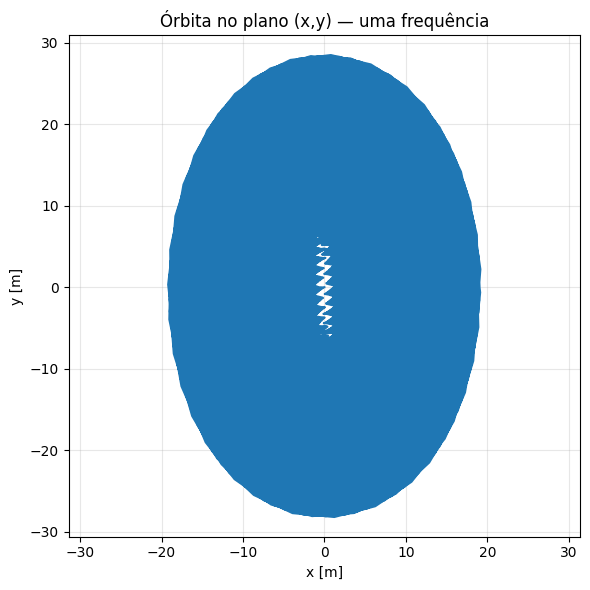

In [5]:
# ================================================================
# CELDA 2A — Figura: Órbita da partícula no plano (x,y)
# ================================================================
# Elegimos una frecuencia dentro de válidas y su k(ω)
mask = np.isfinite(k_vals)
omegas_valid = omegas[mask]; k_valid = k_vals[mask]
omega0 = omegas_valid[len(omegas_valid)//2]  # punto medio de válidos
k0     = k_valid[len(k_valid)//2]

params = dict(E0=CFG.E0, k=float(k0), omega=float(omega0),
              B0=CFG.B0, phi0=CFG.phi0)

y0 = np.array([CFG.x0, CFG.y0, CFG.vx0, CFG.vy0], float)
T, Y = rk4(rhs_particle, y0, 0.0, CFG.T, CFG.dt, params)
x, y, vx, vy = Y[:,0], Y[:,1], Y[:,2], Y[:,3]

plt.figure(figsize=(6,6))
plt.plot(x, y, lw=1.5)
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("Órbita no plano (x,y) — uma frequência")
plt.axis("equal"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Integra uma única partícula-teste sob B0 ẑ e Ex(x,t) = E0 cos(kx-ωt+φ0),
# usando RK4. Plota a trajetória no plano (x,y).
# Fisicamente, vemos o giro ciclotrônico modulado pelo empurrão da onda.



**🔹 Interpretação física — Órbita da partícula**

Em $$B_0 \hat{z}$$, o elétron executa **giro ciclotrônico**.  
A presença da onda elétrica $$E_x(x,t) = E_0 \cos(kx - \omega t + \phi_0)$$ introduz uma modulação:  
a trajetória helicoidal (projetada no plano $$x,y$$) pode alongar-se ou distorcer-se conforme $$\omega$$, $$k$$ e $$\phi_0$$.  

👉 Visualmente, vemos o giro natural com pequenas perturbações sincronizadas pela onda.


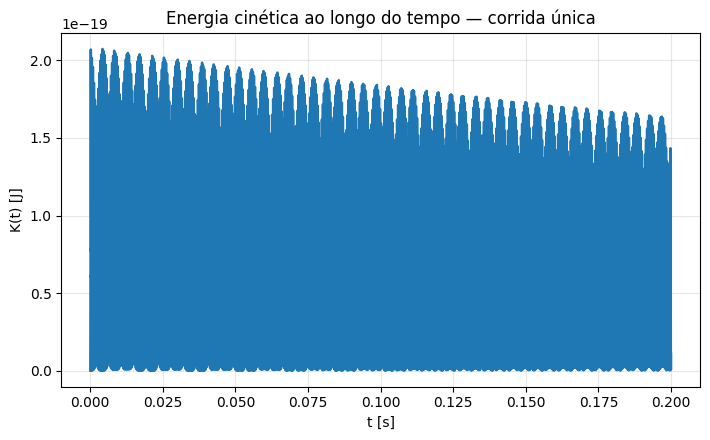

|Ωe|/(2π) ≈ 5598.498 Hz


In [6]:
# ================================================================
# CELDA 2B — Figura: Energia cinética K(t) na mesma corrida
# ================================================================
K = kinetic_energy(vx, vy)

plt.figure(figsize=(7.2,4.5))
plt.plot(T, K, lw=1.8)
plt.xlabel("t [s]"); plt.ylabel("K(t) [J]")
plt.title("Energia cinética ao longo do tempo — corrida única")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

print(f"|Ωe|/(2π) ≈ {np.abs(Oe)/(2*np.pi):.3f} Hz")

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Com os mesmos dados da 2A, calcula e plota a energia cinética K(t).
# Fisicamente, monitora troca de energia partícula–onda; oscilações e/ou
# crescimento próximo da ressonância indicam acoplamento eficiente.


**🔹 Interpretação física — Energia no tempo**

A energia cinética $$K(t)$$ monitora a troca de energia entre a onda e a partícula.  
Longe da ressonância, os empurrões da onda se cancelam e $$K(t)$$ varia pouco.  
Quando $$\omega \approx |\Omega_e|$$, os empurrões ficam em fase com o giro, permitindo **ganho acumulativo de energia**.  

👉 Este é o sinal da **ressonância ciclotrônica**.


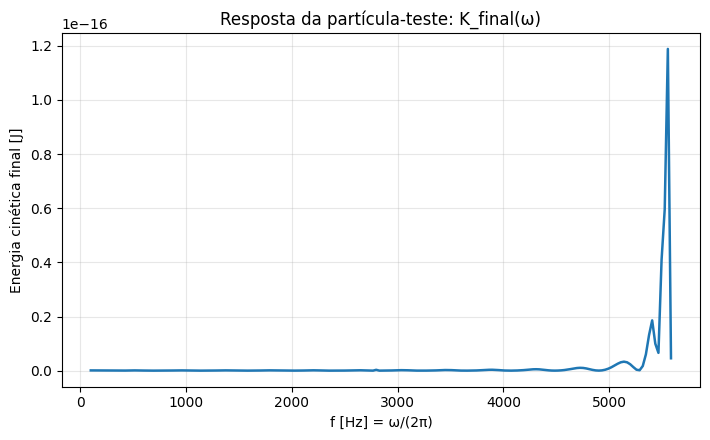

In [7]:
# ================================================================
# CELDA 3 — Figura: Resposta em frequência K_final(ω)
# ================================================================
mask = np.isfinite(k_vals)
omegas_valid = omegas[mask]; k_valid = k_vals[mask]

K_final = []
for omega_i, k_i in zip(omegas_valid, k_valid):
    params_i = dict(E0=CFG.E0, k=float(k_i), omega=float(omega_i),
                    B0=CFG.B0, phi0=CFG.phi0)
    y0 = np.array([CFG.x0, CFG.y0, CFG.vx0, CFG.vy0], float)
    T_i, Y_i = rk4(rhs_particle, y0, 0.0, CFG.T, CFG.dt, params_i)
    K_final.append( kinetic_energy(Y_i[-1,2], Y_i[-1,3]) )

K_final = np.array(K_final)

plt.figure(figsize=(7.2,4.5))
plt.plot(omegas_valid/(2*np.pi), K_final, lw=1.8)
plt.xlabel("f [Hz] = ω/(2π)"); plt.ylabel("Energia cinética final [J]")
plt.title("Resposta da partícula-teste: K_final(ω)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Varre a frequência da onda; para cada ω válido integra a trajetória e
# mede a energia cinética final K_final. Plota K_final(ω).
# Fisicamente, um pico perto de ω≈|Ω_e| caracteriza a ressonância ciclotrônica.



**🔹 Interpretação física — Curva de resposta em frequência**

A curva $$K_{\mathrm{final}}(\omega)$$ mostra um pico nítido próximo a $$\omega \approx |\Omega_e|$$.  
Esse máximo é a assinatura da **ressonância ciclotrônica**, onde o elétron absorve energia da onda de forma mais eficiente.  
A largura e a altura do pico dependem de $$E_0$$, do tempo de integração $$T$$ e das condições iniciais.  

É a principal evidência do acoplamento onda–partícula.


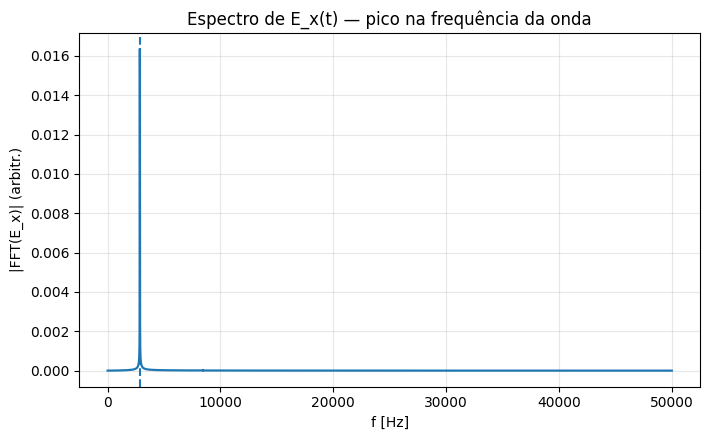

In [8]:
# ================================================================
# CELDA 4 — Figura: FFT de E_x(t) para a mesma corrida da CELDA 2
# ================================================================
Ex_t = CFG.E0*np.cos(params["k"]*x - params["omega"]*T + params["phi0"])

# FFT
N = len(T); dt = T[1]-T[0]
freqs = np.fft.rfftfreq(N, d=dt)
Espec = np.abs(np.fft.rfft(Ex_t)) / N

plt.figure(figsize=(7.2,4.5))
plt.plot(freqs, Espec, lw=1.6)
plt.axvline(params["omega"]/(2*np.pi), ls="--")
plt.xlabel("f [Hz]"); plt.ylabel("|FFT(E_x)| (arbitr.)")
plt.title("Espectro de E_x(t) — pico na frequência da onda")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Para a corrida da 2A, computa FFT do campo elétrico E_x(t) percebido
# ao longo da trajetória e plota o espectro. Fisicamente, deve surgir um
# pico em f≈ω/(2π), validando o conteúdo espectral imposto.


**🔹 Interpretação física — Conteúdo espectral do campo**

O espectro mostra um pico dominante em $$f \approx \omega / (2\pi)$$,  
confirmando que o campo elétrico percebido pela partícula contém o harmônico imposto pela onda plana.  
Pequenas componentes adicionais podem surgir por não linearidades em $$x(t)$$.  

Este gráfico valida o conteúdo espectral da simulação.


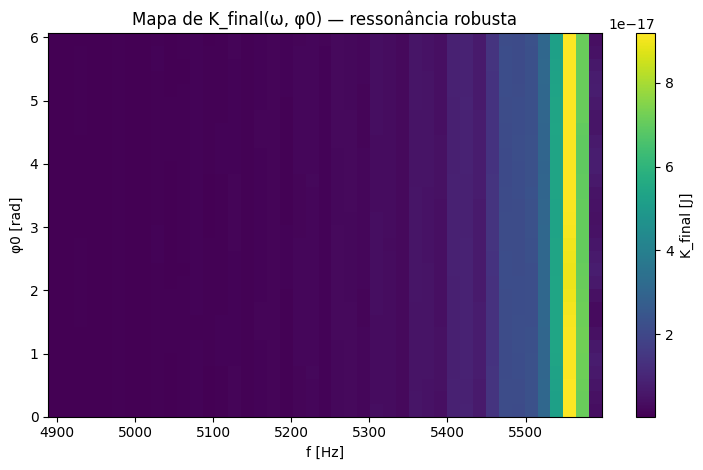

In [9]:
# ================================================================
# CELDA 5 — Figura: Heatmap de K_final(ω, φ0) — varrendo fase inicial
# ================================================================
n_omega_heat = 80
n_phi = 30

# --- Zoom automático alrededor del pico de K_final(ω) obtenido en la CELDA 3 ---
i_peak = int(np.nanargmax(K_final))
omega_peak = float(omegas_valid[i_peak])          # frecuencia angular del pico
f_peak = omega_peak/(2*np.pi)                      # Hz
band = 0.12                                        # ±12% alrededor del pico
fmin = f_peak*(1.0 - band)
fmax = f_peak*(1.0 + band)

# Rejilla de frecuencias centrada en la resonancia
omegas_h = np.linspace(2*np.pi*fmin, 2*np.pi*fmax, n_omega_heat)

# Dispersión fría y filtrado de puntos no propagantes
wpe_h, Oe_h = wpe, Oe
n_h = n_cold_R(omegas_h, wpe_h, Oe_h)
k_h = k_from_n_omega(n_h, omegas_h)
mask_h = np.isfinite(k_h)
omegas_h = omegas_h[mask_h]; k_h = k_h[mask_h]

if omegas_h.size == 0:
    raise ValueError("Heatmap: no hay frecuencias propagantes en la ventana. "
                     "Amplía 'band' o ajusta B0/ne.")

# Parámetros de integración
gyro_T = 2*np.pi/np.abs(Oe_h)                       # período ciclotrón
T_heat = min(CFG.T, 0.08)
dt_max_stable = 0.1*gyro_T                          # criterio dt ≤ 0.1·Tgiro (heurístico)
dt_heat = min(max(CFG.dt, 2*CFG.dt), dt_max_stable) # sube un poco dt, sin romper estabilidad

# Barrido de fase y cálculo del mapa
phis = np.linspace(0.0, 2*np.pi, n_phi, endpoint=False)
Kmap = np.zeros((len(phis), len(omegas_h)))

for j, phi in enumerate(phis):
    for i, (omega_i, k_i) in enumerate(zip(omegas_h, k_h)):
        params_i = dict(E0=CFG.E0, k=float(k_i), omega=float(omega_i),
                        B0=CFG.B0, phi0=float(phi))
        y0 = np.array([CFG.x0, CFG.y0, CFG.vx0, CFG.vy0], float)
        T_i, Y_i = rk4(rhs_particle, y0, 0.0, T_heat, dt_heat, params_i)
        Kmap[j, i] = kinetic_energy(Y_i[-1, 2], Y_i[-1, 3])

# Figura del heatmap
plt.figure(figsize=(7.6, 4.8))
extent = [omegas_h[0]/(2*np.pi), omegas_h[-1]/(2*np.pi), phis[0], phis[-1]]
plt.imshow(Kmap, aspect='auto', origin='lower', extent=extent, interpolation='nearest')
plt.colorbar(label="K_final [J]")
plt.xlabel("f [Hz]"); plt.ylabel("φ0 [rad]")
plt.title("Mapa de K_final(ω, φ0) — ressonância robusta")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Varre ω numa janela centrada na ressonância e várias fases iniciais φ0.
# Para cada par (ω,φ0), integra e registra K_final, construindo um mapa.
# Fisicamente, avalia robustez da ressonância frente à fase da onda.



**🔹 Interpretação física — Robustez da ressonância**

O mapa de calor mostra como a energia final depende de $$\omega$$ e da fase inicial $$\phi_0$$.  
Faixas brilhantes ao redor de $$\omega \approx |\Omega_e|$$ indicam que a ressonância é robusta:  
mantém-se mesmo variando a fase da onda, ainda que a intensidade do ganho varie.  

A ressonância não é pontual — forma uma região contínua no espaço de parâmetros.


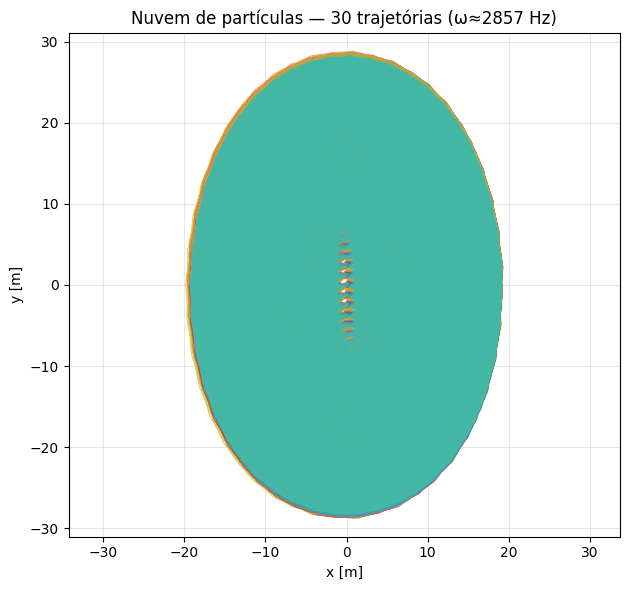

In [10]:
# ================================================================
# CELDA 6A — Nuvem de N partículas (características) — trajetórias médias
# ================================================================
N = 400   # tamaño nube
rng = np.random.default_rng(CFG.seed)
# pequeñas dispersiones iniciales
x0s = CFG.x0 + 1e-1 * rng.standard_normal(N)
y0s = CFG.y0 + 1e-1 * rng.standard_normal(N)
vx0s= CFG.vx0+ 5e3  * rng.standard_normal(N)
vy0s= CFG.vy0+ 5e3  * rng.standard_normal(N)

# usamos la misma (omega0, k0) de Celda 2
params_cloud = dict(E0=CFG.E0, k=float(k0), omega=float(omega0),
                    B0=CFG.B0, phi0=CFG.phi0)

# Integramos solo algunos para visualizar trayectorias
subset = min(30, N)
tray = []
for n in range(subset):
    y0 = np.array([x0s[n], y0s[n], vx0s[n], vy0s[n]], float)
    Tn, Yn = rk4(rhs_particle, y0, 0.0, CFG.T, CFG.dt, params_cloud)
    tray.append(Yn)

plt.figure(figsize=(6.4,6.0))
for Yn in tray:
    plt.plot(Yn[:,0], Yn[:,1], lw=0.8, alpha=0.7)
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title(f"Nuvem de partículas — {subset} trajetórias (ω≈{omega0/(2*np.pi):.0f} Hz)")
plt.axis("equal"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Integra várias partículas com pequenas dispersões iniciais e plota
# diversas trajetórias (x,y). Fisicamente, é uma amostra de características
# do Vlasov: como um conjunto de partículas responde ao mesmo campo.



**🔹 Interpretação física — Resposta coletiva (Mini-Vlasov)**

Diversas partículas, com pequenas diferenças iniciais, evoluem sob o mesmo campo.  
O leque de trajetórias mostra a variedade de respostas:  
algumas ganham mais energia (trajetórias mais amplas), outras menos, conforme a fase instantânea.  

É uma amostra qualitativa do comportamento coletivo descrito pela equação de Vlasov.


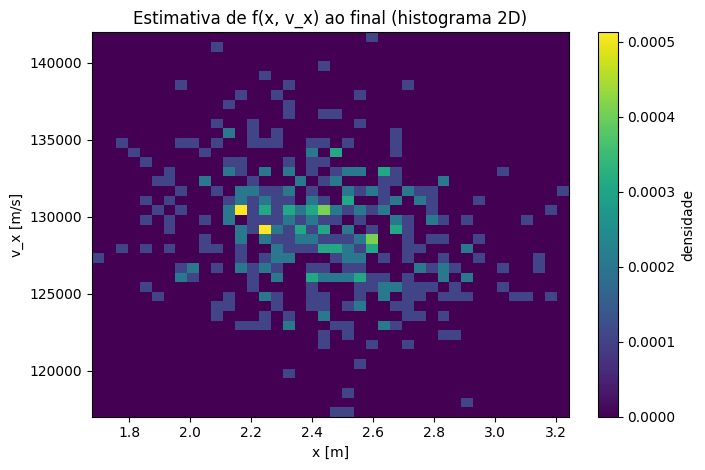

In [11]:
# ================================================================
# CELDA 6B — Histograma 2D (x, vx) ao final: aproximação de f(x,v)
# ================================================================
# Integramos todos pero solo almacenamos estado final
xf, vxf = np.zeros(N), np.zeros(N)
for n in range(N):
    y0 = np.array([x0s[n], y0s[n], vx0s[n], vy0s[n]], float)
    Tn, Yn = rk4(rhs_particle, y0, 0.0, CFG.T, CFG.dt, params_cloud)
    xf[n]  = Yn[-1,0]; vxf[n] = Yn[-1,2]

plt.figure(figsize=(7.2,4.8))
plt.hist2d(xf, vxf, bins=40, density=True)
plt.xlabel("x [m]"); plt.ylabel("v_x [m/s]")
plt.title("Estimativa de f(x, v_x) ao final (histograma 2D)")
plt.colorbar(label="densidade"); plt.tight_layout(); plt.show()


# ---------------------------------------------------------------
# EXPLICAÇÃO:
# A partir da nuvem, monta um histograma 2D no espaço de fase (x, v_x)
# ao final da integração, aproximando f(x,v_x). Fisicamente, inspeciona
# deformações no espaço de fase sob ação da onda (consistente com Liouville).


**🔹 Interpretação física — Estrutura no espaço de fase**

O histograma 2D exibe a densidade da nuvem de partículas no espaço $$(x,v_x)$$ ao final da simulação.  
A distribuição é deformada pela onda, mas o volume total se conserva (Lei de Liouville).  
Regiões mais densas indicam partículas que mantêm fase coerente com o campo.  

Visualiza como a onda reorganiza a distribuição em espaço de fase.


In [11]:
# ================================================================
# CELDA 7A — Animación de la trayectoria (x,y)
# ================================================================
import matplotlib
from matplotlib import animation
from google.colab import files


stride_anim = 10   # muestra 1 de cada 10 puntos
x_anim = x[::stride_anim]
y_anim = y[::stride_anim]
T_anim = T[::stride_anim]

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
ax.set_title("Animación — trayectoria (x,y)")
ax.grid(True, alpha=0.3); ax.set_aspect('equal', adjustable='box')

line, = ax.plot([], [], lw=2)
pt,   = ax.plot([], [], 'o', ms=6)

# Límites con márgenes automáticos
xpad = max(1e-12, 0.02*max(1.0, float(np.ptp(x_anim))))
ypad = max(1e-12, 0.02*max(1.0, float(np.ptp(y_anim))))
ax.set_xlim(float(x_anim.min()-xpad), float(x_anim.max()+xpad))
ax.set_ylim(float(y_anim.min()-ypad), float(y_anim.max()+ypad))

# Funciones de animación
def init():
    line.set_data([], [])
    pt.set_data([], [])
    return line, pt

def animate(i):
    if i == 0:
        line.set_data([x_anim[0]], [y_anim[0]])
        pt.set_data([x_anim[0]], [y_anim[0]])
    else:
        line.set_data(x_anim[:i], y_anim[:i])
        pt.set_data([x_anim[i-1]], [y_anim[i-1]])
    return line, pt

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(T_anim), interval=30, blit=True)

# Guardar y descargar el archivo MP4
output_name = "trajeto.mp4"
ani.save(output_name, fps=30, dpi=120)
plt.close(fig)

# Descargar automáticamente
print(f"✅ Animación guardada como '{output_name}' (MP4)")
files.download(output_name)


# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Gera e salva um vídeo (MP4) da trajetória (x,y) no tempo.
# Fisicamente, visualiza o giro em torno de B0 e a modulação pela onda.
# Obs.: stride/fps controlam tamanho e fluidez do vídeo.



✅ Animación guardada como 'trajeto.mp4' (MP4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**🔹 Interpretação física — Filme da órbita**

A animação mostra o giro do elétron em torno de $$B_0$$ e o efeito modulador da onda whistler.  
Perto da ressonância, a amplitude transversal aumenta visivelmente,  
pois a partícula absorve energia de modo contínuo.  

Permite visualizar dinamicamente a fase e a modulação do giro.


In [12]:
# ================================================================
# CELDA 7B — Animación de energía K(t)
# ================================================================
from matplotlib import animation
from google.colab import files


stride_anim_K = 10   # muestra 1 de cada 10 puntos
T_anim = T[::stride_anim_K]
K_anim = K[::stride_anim_K]

# Configuración del gráfico
fig2, ax2 = plt.subplots(figsize=(7.2,4.5))
ax2.set_xlabel("t [s]"); ax2.set_ylabel("K(t) [J]")
ax2.set_title("Animación — energía cinética K(t)")
ax2.grid(True, alpha=0.3)

line2, = ax2.plot([], [], lw=2)

# límites con un pequeño margen
Kmin, Kmax = float(np.nanmin(K_anim)), float(np.nanmax(K_anim))
if not np.isfinite(Kmin) or not np.isfinite(Kmax) or Kmax <= Kmin:
    Kmin, Kmax = 0.0, 1.0
padK = 0.02*(Kmax - Kmin if Kmax > Kmin else 1.0)
ax2.set_xlim(float(T_anim[0]), float(T_anim[-1]))
ax2.set_ylim(Kmin - padK, Kmax + padK)

# Funciones de animación
def init2():
    line2.set_data([], [])
    return line2,

def animate2(i):
    if i == 0:
        line2.set_data([T_anim[0]], [K_anim[0]])
    else:
        line2.set_data(T_anim[:i], K_anim[:i])
    return line2,

ani2 = animation.FuncAnimation(fig2, animate2, init_func=init2,
                               frames=len(T_anim), interval=30, blit=True)

# Guardar y descargar el archivo MP4
output_name = "energia.mp4"
ani2.save(output_name, fps=30, dpi=120)
plt.close(fig2)

print(f"✅ Animación guardada como '{output_name}' (MP4)")
files.download(output_name)


# ---------------------------------------------------------------
# EXPLICAÇÃO:
# Gera e salva um vídeo (MP4) da evolução da energia cinética K(t).
# Fisicamente, evidencia ganho de energia mais intenso quando ω≈|Ω_e|.
# Obs.: stride/fps controlam tamanho e fluidez do vídeo.



✅ Animación guardada como 'energia.mp4' (MP4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**🔹 Interpretação física — Filme da energia**

O vídeo de $$K(t)$$ mostra como a energia cinética cresce em etapas sincronizadas com o campo elétrico.  
Durante a ressonância, $$K(t)$$ aumenta de forma mais contínua; fora dela, as oscilações se cancelam.  

Torna visível o processo de transferência de energia onda–partícula.
